# Курсовая работа № 2
## Аналитика. Начальный уровень

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

# Подготовка данных

## Заполняем список posts_list необходимой информацией из постов:

In [2]:
vk_token = ''

import pandas as pd

# Добавляем библиотеку для отправки запросов:

import requests

# Ссылка с методом для получения информации о посте:

url = 'https://api.vk.com/method/wall.get'

# Количество постов, получаемых за раз:

count = 100

# Позиция поста, с которой получаем очередную сотню постов:

offset = 0

# Список для записи всех постов со страницы:

posts_list = []

# Определим количество постов:

params = {  
    'owner_id': '-66669811',
    'count': 1,
    'v': 5.95,  
    'access_token': vk_token  
}

response = requests.get(url, params = params)

data = response.json()

# Максимальное количество постов:

max_count = data['response']['count']

# Остаток постов, которые ещё не записаны в список:

leftover = max_count

# Цикл для преодоления ограничений API Вконтакте и записи всех постов в список:

while offset < max_count:
    
    params = {  
        'owner_id': '-66669811',
        'count': count,
        'offset': offset,
        'v': 5.95,  
        'access_token': vk_token  
    }

    response = requests.get(url, params = params)

    data = response.json()
    
    # Цикл для записи очередной сотни постов в список:
    
    for i in range(count):
        
        if leftover > i:
        
            x = data['response']['items'][i]
    
            post_dict = {'id': x['id'], 'date': x['date'], 'text': x['text'],
                        'comment_count': x['comments']['count'], 'like_count': x['likes']['count'], 
                        'repost_count': x['reposts']['count'], 'view_count': '', 'vote_count': ''}
        
            # Вводим по той причине, что были времена, когда у постов не было параметра 'views':
        
            try:
            
                post_dict['view_count'] = x['views']['count']
            
            except Exception:
                    
                pass 
            
            # Ищем среди постов те, где были проведены опросы, и добавляем информацию в список постов:
            
            try:
            
                for j in range(len(x['attachments'])):
                
                    if(x['attachments'][j]['type'] == 'poll'):
                    
                        post_dict['vote_count'] = x['attachments'][j]['poll']['votes']
                        
            except Exception:
                    
                pass            
                
            posts_list.append(post_dict)
            
        else:
            
            break
    
    # Производим актуализацию начала следующей выборки:
    
    offset += count
    
    # Производим актуализацию количества ещё недобавленных постов:
    
    leftover -= count
    
# Создаём датафрейм из списка с постами:    
    
df = pd.DataFrame(posts_list)

## Преобразуем столбец с датами в более привычный вид:

In [3]:
from datetime import datetime, timedelta

df['date'] = df['date'].apply(lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S'))

## Датафрейм со всеми постами со стены Skillbox:

In [4]:
df

,id,date,text,comment_count,like_count,repost_count,view_count,vote_count
0,215343,2021-11-01 14:32:31,"Нет, это не шутка! Попробовать 34 курса и инте...",42,202,369,33226,
1,220507,2021-11-19 12:30:39,"Славянская мифология, русская культура, советс...",0,18,6,5204,
2,220384,2021-11-18 20:04:53,С удовольствием смотрите фильмы вроде «Банды Н...,0,12,3,8081,
3,220271,2021-11-18 13:05:00,Выбрать профессию по душе — задача точно не из...,0,10,5,10629,
4,220256,2021-11-18 11:40:22,"Говорят, что красота требует жертв. На самом д...",0,197,187,18910,
...,...,...,...,...,...,...,...,...
3896,19003,2016-04-03 15:10:10,#internetmarketing #business #skillbox\n\n15 с...,0,4,0,,
3897,18999,2016-04-02 20:04:13,#internetmarketing #business #skillbox\n\nБлес...,0,1,0,,
3898,18998,2016-04-02 15:05:19,#movie #internetmarketing #business #skillbox ...,0,3,0,,
3899,18994,2016-04-01 16:50:13,#studio #business #skillbox \n\n4 вида рекламн...,0,6,0,,


# 1. Проанализируем влияние фактора времени на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Активность будем определять не в абсолютных значениях, а относительно количества просмотров постов.

In [106]:
import warnings

warnings.filterwarnings("ignore")

# Ограничим первоначальный датафрейм строками, в которых имеются данные о количестве просомтров постов:

df_with_view = df[df['view_count'] != '']

# Приведём даты к формату datetime:

df_with_view['date'] = pd.to_datetime(df_with_view['date'])

# Приведём тип данных столбцов  'view_count' и 'vote_count' к типу int:

df_with_view['view_count'] = pd.to_numeric(df_with_view['view_count'])

df_with_view['vote_count'] = pd.to_numeric(df_with_view['vote_count'])

## Датафрейм, содержащий только посты со статистикой просмотров:

In [107]:
df_with_view

,id,date,text,comment_count,like_count,repost_count,view_count,vote_count
0,215343,2021-11-01 14:32:31,"Нет, это не шутка! Попробовать 34 курса и инте...",42,202,369,33226,NaN
1,220507,2021-11-19 12:30:39,"Славянская мифология, русская культура, советс...",0,18,6,5204,NaN
2,220384,2021-11-18 20:04:53,С удовольствием смотрите фильмы вроде «Банды Н...,0,12,3,8081,NaN
3,220271,2021-11-18 13:05:00,Выбрать профессию по душе — задача точно не из...,0,10,5,10629,NaN
4,220256,2021-11-18 11:40:22,"Говорят, что красота требует жертв. На самом д...",0,197,187,18910,NaN
...,...,...,...,...,...,...,...,...
3381,20610,2017-02-09 13:01:49,#дизайнпонедельник - выпуск №7 - Как сделать с...,0,33,2,3671,NaN
3382,20607,2017-02-08 14:21:27,#дизайнпонедельник - выпуск №6 - Профессиональ...,0,22,1,3517,NaN
3383,20550,2017-01-19 21:03:29,,6,20,2,5972,NaN
3384,20547,2017-01-18 20:56:32,,5,7,1,5468,NaN


# 1.1. Выясним, как зависят показатели вовлечённости от месяца в году:
Кроме того выясним, как соотносятся показатели вовлечённости с количеством просмотров и количеством постов

In [108]:
# Скопируем исходный датафрейм:

df_with_view_1_1 = df_with_view.copy()

# Добавим столбец 'count of posts' для подсчёта количества постов в дальнейшем:

df_with_view_1_1['count_of_posts'] = 1

# Добавим столбцы с информацией о годе и месяце размещения поста:

df_with_view_1_1['year'] = df_with_view_1_1['date'].dt.year

df_with_view_1_1['month'] = df_with_view_1_1['date'].dt.month

# Произведём группировку датафрейма по годам и месяцам, оставим только показатели вовлечённости:

grouped_df_with_view_1_1 = df_with_view_1_1.groupby(['year', 'month']).agg({'comment_count' : 'median',
                                                                     'like_count' : 'median',
                                                                     'repost_count' : 'median',
                                                                     'view_count' : 'median',
                                                                     'vote_count' : 'median',
                                                                     'count_of_posts' : 'sum'}).reset_index()

# Заменим значения Nan для 'vote_count' на 0:

grouped_df_with_view_1_1['vote_count'] = grouped_df_with_view_1_1['vote_count'].fillna(0)

# Добавим в датафрейм новый столбец с датой замера средних показателей вовлечённости: 

grouped_df_with_view_1_1['control_date'] = pd.to_datetime(grouped_df_with_view_1_1.year.astype(str) 
                                                          + grouped_df_with_view_1_1.month.astype(str), format='%Y%m')

## Медианные показатели вовлечённости по годам и месяцам (период с января 2017 по сентябрь 2021):

In [109]:
grouped_df_with_view_1_1

,year,month,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts,control_date
0,2017,1,6.0,20.0,2.0,5972.0,0.0,3,2017-01-01
1,2017,2,0.0,15.0,1.0,3239.0,0.0,9,2017-02-01
2,2017,4,0.0,13.0,1.0,3416.0,0.0,19,2017-04-01
3,2017,5,0.0,38.0,5.0,8442.0,0.0,11,2017-05-01
4,2017,6,8.0,24.0,1.0,12194.0,0.0,3,2017-06-01
5,2017,7,3.5,21.5,1.5,8157.5,606.5,6,2017-07-01
6,2017,8,8.0,23.0,2.0,7782.0,508.0,9,2017-08-01
7,2017,9,4.0,18.0,0.0,9438.0,0.0,7,2017-09-01
8,2017,10,2.0,12.0,1.0,8764.0,426.0,11,2017-10-01
9,2017,11,3.5,16.0,1.0,8354.0,491.0,18,2017-11-01


## Построим графики зависимости показателей вовлечённости, количества просмотров и количества постов от месяца и года (период с января 2017 по сентябрь 2021):

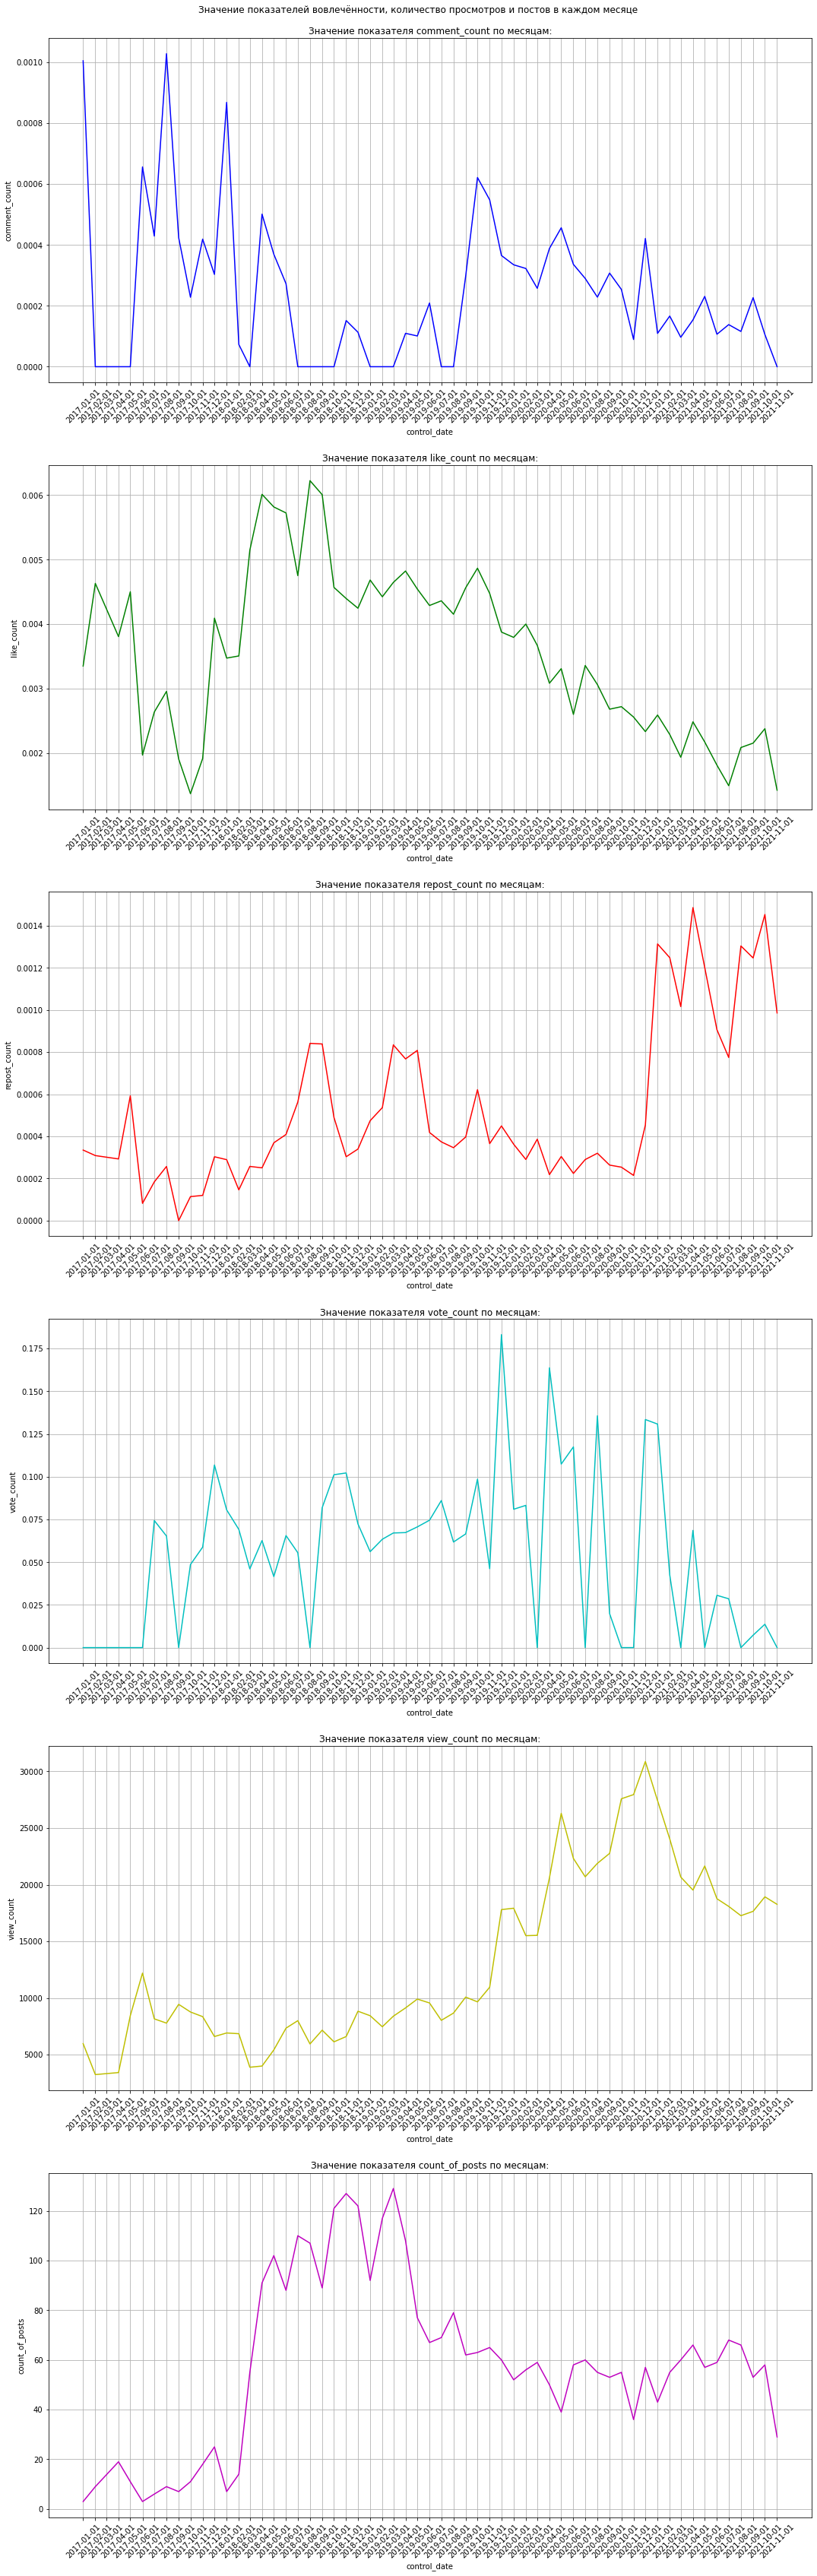

In [110]:
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

# Создадим список закодированных цветов для получения графиков разных цветов:

colors = ['b', 'g', 'r', 'c', 'y', 'm']

# Cоздадим список контрольных дат для кастомной разбивки оси x по контрольным датам:

control_date_list = []

# Создадим первую контрольную дату и добавим её в список:

first_date = pd.to_datetime('2017' + '01' + '01', format='%Y%m%d').date()

control_date_list.append(first_date)

# Создадим цикл для добавления в список первого числа каждого месяца каждого года из диапазона 
# каждый месяц в диапазоне от января 2017 до сентября 2021 включительно:

for i in range(1,59):
    
    control_date_list.append((control_date_list[i-1] + relativedelta(months=+1)))
    
# Создадим фигуру с 4 пустыми полями для графиков:

fig, axs = plt.subplots(figsize=(18, 60), nrows=6)

inclusion_indicator_list = ['comment_count', 'like_count', 'repost_count', 'vote_count', 'view_count', 'count_of_posts']

# Заполним фигуры значениями из датафрейма:

for i in range(len(inclusion_indicator_list)):
    
    # Создадим вспомогательный датафрейм для конкретного показателя:
    
    if (inclusion_indicator_list[i] == 'view_count')|(inclusion_indicator_list[i] == 'count_of_posts'):
        
        data = grouped_df_with_view_1_1[['control_date', inclusion_indicator_list[i]]]
        
        data['rilative_indicator'] = data[inclusion_indicator_list[i]]
        
    else:
        
        data = grouped_df_with_view_1_1[['control_date', inclusion_indicator_list[i], 'view_count']]
    
        data['rilative_indicator'] = data[inclusion_indicator_list[i]]/data['view_count']
    
    # Создадим ссылку на элемент из списка axs:
    
    ax = axs[i]
    
    # Построим график, задав стобцы вспомогательного датафрейма в качестве значений для осей x и y и указав цвет графика:
    
    ax.plot(data['control_date'], data['rilative_indicator'], color=colors[i])
    
    # Установим наименование оси y:
    
    ax.set_ylabel(inclusion_indicator_list[i])
    
    # Установим наименование оси x:
    
    ax.set_xlabel('control_date')
    
    # Установим наименование заголовка графика:

    ax.set_title('Значение показателя ' + inclusion_indicator_list[i] + ' по месяцам:') 
    
    # Задаим поворот значений на 45 градусов для оси x:
    
    ax.tick_params(axis='x', labelrotation=45)
    
    # Сделаем разбивку оси x по контрольным датам из списка 'control_date_list':

    ax.set_xticks(control_date_list)

    ax.set_xticklabels(control_date_list)
    
    # Добавим сетку:
    
    ax.grid()
    
# Установим наименование заголовка фигуры:
    
fig.suptitle("Значение показателей вовлечённости, количество просмотров и постов в каждом месяце", y=0.89)  

# Зададим отступы между графиками:

plt.subplots_adjust(wspace = 0, hspace = 0.24)
  
# Покажем графики:

plt.show()

## Выводы:

Видим, что в 19 году началось снижение всех показателей вовлечённости, которое продолжается до сих пор. Исключением является количество репостов, которое в течение 21 года держится на более высоком уровне.

При этом количество просмотров росло с 19 до 21 года. Только с начала 21 года количество просмотров начало падение.

Количество постов в месяц в мае 2019 года сократилось в 2 раза.
Возможно, что снижение количества постов повлияло на показатели вовлечённости. Либо оно является индикатором других явлений. Снижение количества постов может говорить как о том, что их просто стали писать меньше, так и о том, что стало меньше интересных тем, отчего упала производительность написания текстов. Может быть авторы текстов начали повторяться.

Исходя из вышеуказанного рекомендуется изучить, чем ещё отличаются периоды до 19 года и от 19 года включительно. Менялись ли авторы текстов и с чем связано снижение количества постов.

# 1.2. Выясним, как зависят показатели вовлечённости от времени в течение дня:

In [38]:
import warnings

warnings.filterwarnings('ignore')

# Скопируем исходный датафрейм:

df_with_view_1_2 = df_with_view.copy()

# Добавим столбцы с информацией о часе размещения поста:

df_with_view_1_2['hour'] = df_with_view_1_2['date'].dt.hour

df_with_view_1_2

# Произведём группировку датафрейма по часам, оставим только показатели вовлечённости:

grouped_df_with_view_1_2 = df_with_view_1_2.groupby('hour')[['comment_count', 'like_count', 
                                                                'repost_count', 'view_count',
                                                                'vote_count']].mean().reset_index()

# Заменим значения Nan для 'vote_count' на 0:

grouped_df_with_view_1_2['vote_count'] = grouped_df_with_view_1_2['vote_count'].fillna(0)

## Средние показатели вовлечённости по часам:

In [39]:
grouped_df_with_view_1_2

,hour,comment_count,like_count,repost_count,view_count,vote_count
0,0,0.000000,15.000000,2.000000,6719.000000,0.000000
1,9,5.000000,73.000000,10.000000,18178.000000,0.000000
2,10,7.545455,43.363636,6.636364,11985.727273,0.000000
3,11,11.452297,66.261484,18.798587,17048.289753,259.000000
4,12,12.228070,83.750000,21.701754,18874.811404,1065.818182
5,13,10.378378,86.168919,20.125000,19427.807432,956.466667
6,14,9.165354,83.704724,20.370079,18969.314961,1546.300000
7,15,8.837079,70.646067,16.067416,18930.567416,1532.363636
8,16,3.818854,60.164510,11.761553,14066.188540,557.636364
9,17,12.803797,73.329114,18.303797,28391.898734,1049.000000


## Построим графики зависимости показателей вовлечённости от часа суток (один график для каждого показателя):

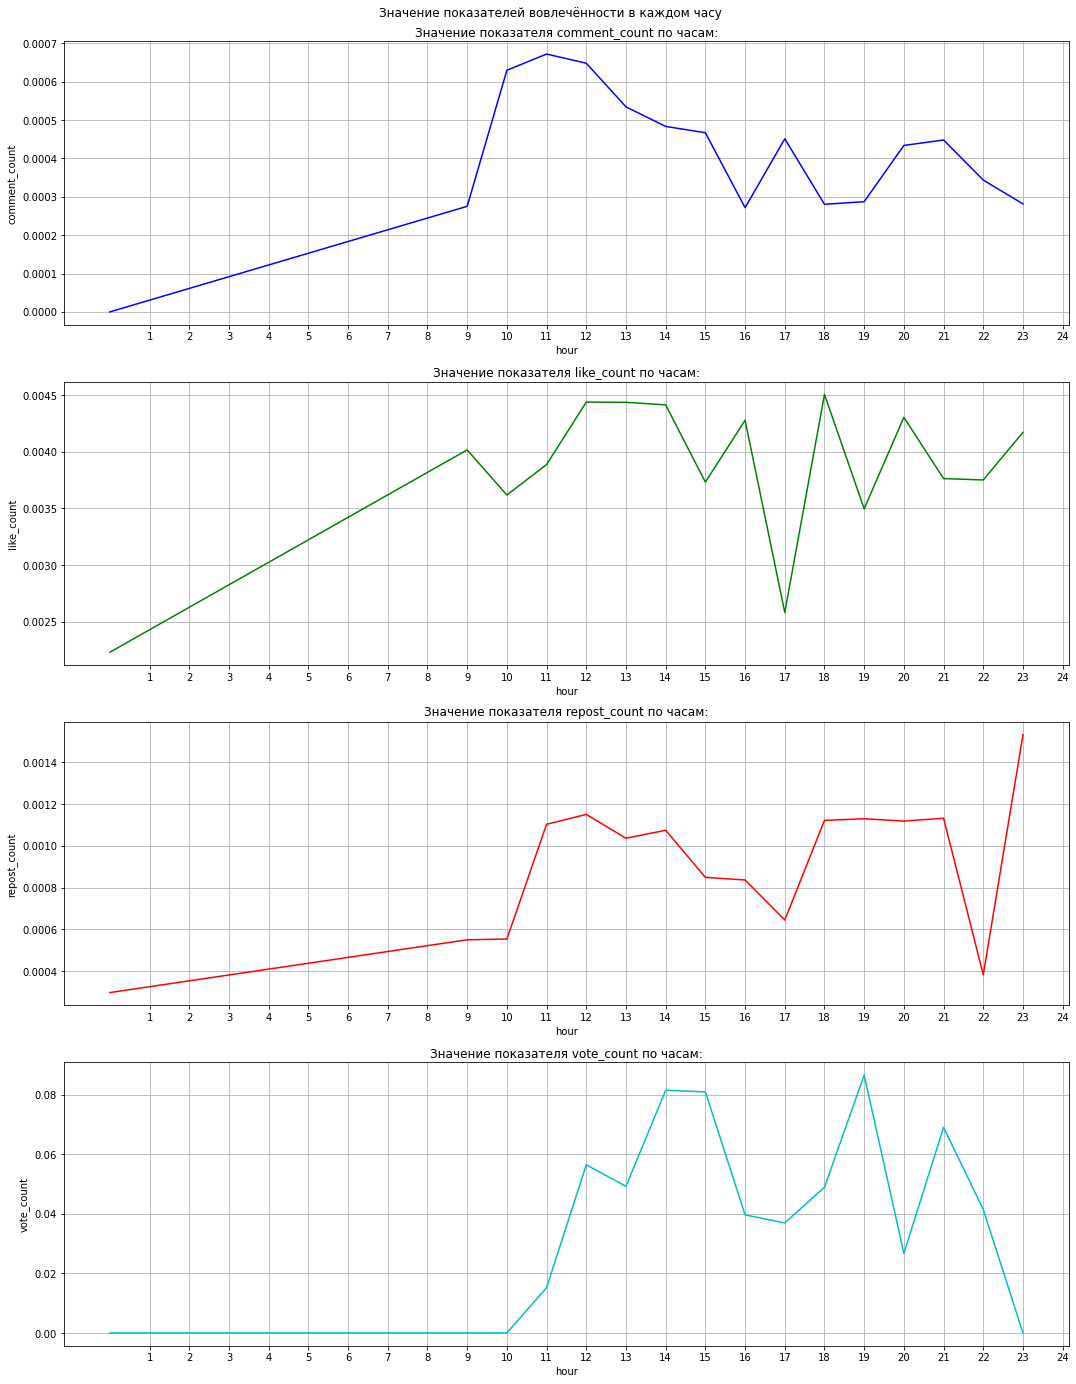

In [111]:
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

# Создадим список закодированных цветов для получения графиков разных цветов:

colors = ['b', 'g', 'r', 'c']

# Создадим список с часами:

hour_list = range(1,25)
    
# Создадим фигуру с 4 пустыми полями для графиков:

fig, axs = plt.subplots(figsize=(18, 24), nrows=4)

inclusion_indicator_list_2 = ['comment_count', 'like_count', 'repost_count', 'vote_count']

# Заполним фигуры значениями из датафрейма:

for i in range(len(inclusion_indicator_list_2)):
    
    # Создадим вспомогательный датафрейм для конкретного 'course_name':
    
    data = grouped_df_with_view_1_2[['hour', inclusion_indicator_list_2[i], 'view_count']]
    
    data['rilative_indicator'] = data[inclusion_indicator_list_2[i]]/data['view_count']
    
    # Создадим ссылку на элемент из списка axs:
    
    ax = axs[i]
    
    # Построим график, задав стобцы вспомогательного датафрейма в качестве значений для осей x и y и указав цвет графика:
    
    ax.plot(data['hour'], data['rilative_indicator'], color=colors[i])
    
    # Установим наименование оси y:
    
    ax.set_ylabel(inclusion_indicator_list_2[i])
    
    # Установим наименование оси x:
    
    ax.set_xlabel('hour')
    
    # Установим наименование заголовка графика:

    ax.set_title('Значение показателя ' + inclusion_indicator_list_2[i] + ' по часам:') 

    # Зададим разбивку оси x по часам:

    ax.set_xticks(hour_list)

    ax.set_xticklabels(hour_list)    
    
    # Добавим сетку:
    
    ax.grid()
    
# Установим наименование заголовка фигуры:
    
fig.suptitle("Значение показателей вовлечённости в каждом часу", y=0.9)  

# Зададим отступы между графиками:

plt.subplots_adjust(wspace = 0, hspace = 0.2)
  
# Покажем графики:

plt.show()

## Определим время в течение дня, когда размещать посты наиболее эффективно с точки зрения всех показателей вовлечённости:

In [134]:
grouped_df_1_3 = grouped_df_with_view_1_2.copy()

def make_relative(indicator):
    
    grouped_df_1_3['rilative_' + indicator] = grouped_df_1_3[indicator]/grouped_df_1_3['view_count']
    
    pass

def make_normal(indicator):
    
    grouped_df_1_3['normal_' + indicator] = grouped_df_1_3['rilative_'+indicator]/grouped_df_1_3['rilative_'+indicator].max()
    
    pass

# Получим новые столбцы со значениями показателей вовлечённости относительно количества просмотров
# и приведём максимальные значения относительных показателей вовлечённости к 1:

for i in inclusion_indicator_list_2:
    
    make_relative(i)
    
    make_normal(i)

# Создадим новый датафрейм, в котором оставим только необходимые нам столбцы:

normal_df_1_3 = grouped_df_1_3[['hour', 'normal_comment_count', 
                                'normal_like_count', 'normal_repost_count', 'normal_vote_count']]

normal_df_1_3['optimal_indicator'] = (normal_df_1_3['normal_comment_count'] + normal_df_1_3['normal_like_count'] 
                                      + normal_df_1_3['normal_repost_count'] + normal_df_1_3['normal_vote_count'])

# Отсортируем датафрейм по показателю 'optimal_indicator':

normal_df_1_3.sort_values('optimal_indicator', ascending=False)

,hour,normal_comment_count,normal_like_count,normal_repost_count,normal_vote_count,optimal_indicator
4,12,0.964414,0.984919,0.751057,0.651989,3.352379
6,14,0.719260,0.979483,0.701458,0.941200,3.341401
13,21,0.666637,0.835265,0.739138,0.797394,3.038433
5,13,0.795232,0.984522,0.676663,0.568442,3.024859
7,15,0.694918,0.828367,0.554425,0.934627,3.012336
11,19,0.427416,0.776246,0.737552,1.000000,2.941214
3,11,1.000000,0.862738,0.720286,0.175412,2.758435
10,18,0.417281,1.000000,0.732318,0.565197,2.714796
12,20,0.645522,0.955165,0.730150,0.308479,2.639315
8,16,0.404152,0.949429,0.546196,0.457735,2.357513


## Рекомендуемое время размещения поста:

In [131]:
print(str(normal_df_1_3['hour'][normal_df_1_3['optimal_indicator'] == normal_df_1_3['optimal_indicator'].max()].iloc[0]) 
      + ' hours')

12 hours


# 2. Произведём аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике.

In [114]:
import re

# Скопируем исходный датафрейм:

df_with_view_2 = df_with_view.copy()

# Выражение для поиска тега в посте:

pattern = r'[#]\w+'

# Добавим столбец с тегами:

df_with_view_2['tags'] = df_with_view_2['text'].apply(lambda x : re.findall(pattern, x))

# Заменим Nan-ы в столбце tags на '#somecategory':

df_with_view_2['tags'].fillna('#somecategory', inplace=True)

# Есть строки, у которых в столбце tags содержатся списки из нескольких тегов. Разобъём эти строки на несколько:

df_with_view_2_2 = df_with_view_2.explode('tags')

# Сгруппируем посты по тегам и определим количество постов для каждого тега:

grouped_df_with_view_2 = df_with_view_2_2.groupby('tags')['id'].count().reset_index()

# Переименуем столбец 'id', чтобы заголовок отражал суть содержимого столбца:

grouped_df_with_view_2.rename(columns = {'id':'count_of_posts'}, inplace = True)

## Датафрейм, содержащий информацию о тегах и количестве постов с такими тегами:

In [115]:
grouped_df_with_view_2

,tags,count_of_posts
0,#0oj0Vs,1
1,#10,1
2,#191970,1
3,#2,1
4,#3D_графика_Skillbox,1
...,...,...
405,#статья_Skillbox,1
406,#статья_skillbox,76
407,#студенты_skillbox,2
408,#фотостокчеллендж,1


## Видим, что в столбце с тегами есть невнятные значения вроде чисел или наборов букв и цифр. Кроме того есть теги очень похожие друг на друга, которые явно нуждаются в обобщении. Далее проведём обобщение и определим категорию каждого поста:

In [48]:
# Создадим список рубрик (категорий): 

category_list = ['дизайн', 'маркетинг', 'программирование', 'курс', 'вдохновляет', 
                 'игра', 'совет', 'трудоустройство', 'управление', 'calendar',
                'drevolution', 'friday_typeface', 'history', 'read', 'reviews',
                'анонс', 'team', ' айдентик', 'закладки', 'вебинар', 'кейс',
                'конкурс', 'лекторий', 'марафон', 'новости', 'расписание',
                'работа студента', 'статья', 'образование', 'answer', 'баттл', 
                 'offf', 'игра по управлению', 'collection', 'моушн', 
                 'психология', 'мультимедиа', 'лояльность', 'business_school', 
                 'день']

# Создадим список рубрик (категорий) для поиска по тексту:

category_list_2 = ['дизайн', 'маркетинг', 'программирование', 'игра',
                 'трудоустройство', 'управление','совет', 'фриланс',
                'drevolution', 'friday_typeface', 'history', 'английский',
                'анонс', 'team', ' айдентик', 'закладки', 'вебинар',
                'конкурс', 'лекторий', 'марафон', 'расписание',
                'баттл', 'кейс', 'offf', 'моушн', 'business_school',
                 'психология', 'мультимедиа', 'лояльность', 'youtube']

# Составим словарь, в котором ключами будут являться слова, которые ассоциируются с категориями из списка категорий, 
# а значениями - сами категории:

category_dict = {'мркетинг': 'маркетинг',
                 'marketing': 'маркетинг',
                 'code': 'программирование',
                 'design': 'дизайн',
                 'management': 'управление',
                 'weekbook': 'read',
                 'иллюстрация': 'дизайн',
                 'вакансии': 'трудоустройство',
                 'карьер': 'трудоустройство',
                 'полезное': 'совет',
                 'cтудент': 'работа студента',
                 'шрифт': 'дизайн',
                 'бакалавриат': 'образование',
                 'РАНХиГС': 'образование',
                 'моушен': 'моушн',
                 'battle': 'баттл',
                 'графика': 'дизайн',
                 'анимация': 'дизайн',
                 'MBA': 'образование',
                 'гейм': 'игра',
                 'игры': 'игра',
                 'фотошоп': 'дизайн',
                 'photoshop': 'дизайн',
                 'кант': 'образование',
                 'английск': 'английский',
                 'по_управлению': 'игра по управлению',
                 'поуправлению': 'игра по управлению',
                 'работы_студентов': 'работа студента',
                 'работа_cтудента': 'работа студента'}

# Создадим список списков для добавления категорий:

category_list_for_df = []

# Заполним список пустыми списками для дальнейшего добавления категорий:

for i in range(len(df_with_view_2)):
    
    category_list_for_df.append([])
    
# Определим категорию для каждой строки датафрейма 'df_with_view_2':

for i in range(len(df_with_view_2)):
    
    # Заполним ячейку списка 'category_list_for_df' значениями из списка 'category_list', 
    # которые содержатся в соответствующей ячейке df_with_view_2['tags']:
        
    for j in range(len(category_list)):
        
        if category_list[j] in str(df_with_view_2['tags'][i]).lower():
            
            category_list_for_df[i].append(category_list[j])
      
    # Если мы ещё не заполнили ячейку списка 'category_list_for_df', добавим в неё значения, соответствующие ключам из
    # словаря 'category_dict', которые содержатся в соответствующей ячейке df_with_view_2['tags']:    
    
    if category_list_for_df[i] == []:
        
        for k in range(len(category_dict.keys())):
            
            if list(category_dict.keys())[k] in str(df_with_view_2['tags'][i]).lower():
                
                category_list_for_df[i].append(category_dict[list(category_dict.keys())[k]])
                
    # Если мы всё ещё не заполнили ячейку списка 'category_list_for_df', добавим в неё значения из списка 'category_list', 
    # которые содержатся в соответствующей ячейке df_with_view_2['text']:
    
    if category_list_for_df[i] == []:
        
        for p in range(len(category_list_2)):
            
            if category_list_for_df[i] == []:
        
                if category_list_2[p] in str(df_with_view_2['text'][i]).lower():
            
                    category_list_for_df[i].append(category_list_2[p])
                
    # Если мы ещё не заполнили ячейку списка 'category_list_for_df', добавим в неё значения, соответствующие ключам из
    # словаря 'category_dict', которые содержатся в соответствующей ячейке df_with_view_2['text']:    
    
    if category_list_for_df[i] == []:
        
        for t in range(len(category_dict.keys())):
            
            if category_list_for_df[i] == []:
            
                if list(category_dict.keys())[t] in str(df_with_view_2['text'][i]).lower():
                
                    category_list_for_df[i].append(category_dict[list(category_dict.keys())[t]])               
                
    # Если ячейка всё ещё пустая, заполним её значением 'other':
    
    if category_list_for_df[i] == []:
    
        category_list_for_df[i].append('other')
            
# Добавим в датафрейм 'df_with_view_2' столбец с категориями:

df_with_view_2['category'] = pd.Series(category_list_for_df)

# Есть строки, у которых в столбце 'category' содержатся списки из нескольких категорий. Разобъём эти строки на несколько:

df_with_view_2_3 = df_with_view_2.explode('category')

# Для подсчёта количества столбцов по категориям добавим столбец:

df_with_view_2_3['count_of_posts'] = 1

## Датафрейм, содержащий информацию о категориях для каждого поста:

In [49]:
df_with_view_2_3

,id,date,text,comment_count,like_count,repost_count,view_count,vote_count,tags,category,count_of_posts
0,215343,2021-11-01 14:32:31,"Нет, это не шутка! Попробовать 34 курса и инте...",42,202,369,33226,NaN,[],other,1
1,220507,2021-11-19 12:30:39,"Славянская мифология, русская культура, советс...",0,18,6,5204,NaN,[#Skillbox_дизайн],дизайн,1
2,220384,2021-11-18 20:04:53,С удовольствием смотрите фильмы вроде «Банды Н...,0,12,3,8081,NaN,[],other,1
3,220271,2021-11-18 13:05:00,Выбрать профессию по душе — задача точно не из...,0,10,5,10629,NaN,[],other,1
4,220256,2021-11-18 11:40:22,"Говорят, что красота требует жертв. На самом д...",0,197,187,18910,NaN,[],other,1
...,...,...,...,...,...,...,...,...,...,...,...
3381,20610,2017-02-09 13:01:49,#дизайнпонедельник - выпуск №7 - Как сделать с...,0,33,2,3671,NaN,[#дизайнпонедельник],дизайн,1
3382,20607,2017-02-08 14:21:27,#дизайнпонедельник - выпуск №6 - Профессиональ...,0,22,1,3517,NaN,[#дизайнпонедельник],дизайн,1
3383,20550,2017-01-19 21:03:29,,6,20,2,5972,NaN,[],other,1
3384,20547,2017-01-18 20:56:32,,5,7,1,5468,NaN,[],other,1


## Наконец займёмся аналитикой показателей вовлечённости:

In [50]:
# Произведём группировку датафрейма по категориям, оставим только показатели вовлечённости:

grouped_df_with_view_2_3 = df_with_view_2_3.groupby('category').agg({'comment_count' : 'mean',
                                                                     'like_count' : 'mean',
                                                                     'repost_count' : 'mean',
                                                                     'view_count' : 'mean',
                                                                     'vote_count' : 'mean',
                                                                     'count_of_posts' : 'sum'}).reset_index()

# Заменим значения Nan для 'vote_count' на 0:

grouped_df_with_view_2_3['vote_count'] = grouped_df_with_view_2_3['vote_count'].fillna(0)

## Средние показатели вовлечённости по категориям:

In [116]:
grouped_df_with_view_2_3

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
0,answer,46.255814,10.209302,0.558140,8110.488372,0.000000,43
1,business_school,5.333333,34.666667,18.000000,18216.000000,0.000000,3
2,calendar,7.960000,25.660000,2.040000,6644.460000,0.000000,50
3,collection,1.480315,134.133858,32.031496,18878.779528,124.000000,127
4,drevolution,1.529412,36.588235,2.117647,7612.823529,0.000000,17
5,friday_typeface,3.260000,69.720000,8.080000,10910.320000,267.000000,50
6,history,1.432432,34.351351,3.810811,7219.810811,0.000000,37
7,offf,11.285714,36.428571,2.928571,18293.071429,0.000000,14
8,other,8.257426,71.490099,28.472772,20539.655941,692.909091,404
9,read,1.061125,46.354523,8.655257,8916.496333,0.000000,409


## Категории-лидеры по комментариям:

In [139]:
grouped_df_with_view_2_3.sort_values(by='comment_count', ascending=False).head(10)

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
0,answer,46.255814,10.209302,0.558140,8110.488372,0.000000,43
23,конкурс,36.681818,78.727273,10.750000,22746.431818,0.000000,44
24,курс,27.666667,75.894737,11.368421,23549.614035,0.000000,57
29,моушн,25.750000,151.250000,12.750000,26592.000000,0.000000,4
18,день,18.210526,99.842105,20.368421,26470.473684,0.000000,19
27,марафон,18.200000,49.600000,8.600000,23577.600000,0.000000,15
15,баттл,14.516129,22.854839,2.306452,10687.564516,1104.232558,62
16,вдохновляет,13.533333,130.222222,17.266667,23164.777778,0.000000,45
22,кейс,13.000000,95.285714,9.761905,19203.833333,505.500000,42
21,игра,11.666667,47.898551,16.115942,15680.942029,570.363636,69


## Категории-лидеры по лайкам:

In [140]:
grouped_df_with_view_2_3.sort_values(by='like_count', ascending=False).head(10)

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
20,закладки,9.768817,160.118280,39.741935,28184.935484,0.0,186
29,моушн,25.750000,151.250000,12.750000,26592.000000,0.0,4
3,collection,1.480315,134.133858,32.031496,18878.779528,124.0,127
16,вдохновляет,13.533333,130.222222,17.266667,23164.777778,0.0,45
36,совет,4.744681,102.340426,38.893617,20769.489362,282.0,47
18,день,18.210526,99.842105,20.368421,26470.473684,0.0,19
22,кейс,13.000000,95.285714,9.761905,19203.833333,505.5,42
31,новости,8.166667,93.500000,13.166667,29383.500000,0.0,6
23,конкурс,36.681818,78.727273,10.750000,22746.431818,0.0,44
24,курс,27.666667,75.894737,11.368421,23549.614035,0.0,57


## Категории-лидеры по репостам:

In [141]:
grouped_df_with_view_2_3.sort_values(by='repost_count', ascending=False).head(10)

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
20,закладки,9.768817,160.118280,39.741935,28184.935484,0.000000,186
36,совет,4.744681,102.340426,38.893617,20769.489362,282.000000,47
40,фриланс,6.500000,58.500000,35.500000,12726.166667,0.000000,6
3,collection,1.480315,134.133858,32.031496,18878.779528,124.000000,127
34,психология,10.333333,37.333333,30.666667,15992.000000,0.000000,3
8,other,8.257426,71.490099,28.472772,20539.655941,692.909091,404
13,английский,3.700000,49.800000,25.800000,14851.400000,0.000000,10
39,управление,6.871795,75.188034,20.854701,18208.341880,521.363636,117
18,день,18.210526,99.842105,20.368421,26470.473684,0.000000,19
38,трудоустройство,7.560000,48.400000,19.560000,23880.600000,0.000000,25


## Категории-лидеры по голосующим:

In [142]:
grouped_df_with_view_2_3.sort_values(by='vote_count', ascending=False).head(10)

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
15,баттл,14.516129,22.854839,2.306452,10687.564516,1104.232558,62
19,дизайн,7.748052,73.510390,13.649351,16345.067532,1038.827586,770
33,программирование,7.516529,70.946281,14.801653,18331.169421,713.500000,242
8,other,8.257426,71.490099,28.472772,20539.655941,692.909091,404
21,игра,11.666667,47.898551,16.115942,15680.942029,570.363636,69
39,управление,6.871795,75.188034,20.854701,18208.341880,521.363636,117
22,кейс,13.000000,95.285714,9.761905,19203.833333,505.500000,42
28,маркетинг,6.345304,72.933702,18.925414,17746.748619,400.333333,362
37,статья,4.962428,61.647399,17.601156,17674.575145,302.000000,346
14,анонс,4.633803,36.690141,18.549296,18646.450704,299.000000,71


## Категории-лидеры по количеству постов:

In [143]:
grouped_df_with_view_2_3.sort_values(by='count_of_posts', ascending=False).head(10)

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
19,дизайн,7.748052,73.510390,13.649351,16345.067532,1038.827586,770
9,read,1.061125,46.354523,8.655257,8916.496333,0.000000,409
8,other,8.257426,71.490099,28.472772,20539.655941,692.909091,404
28,маркетинг,6.345304,72.933702,18.925414,17746.748619,400.333333,362
37,статья,4.962428,61.647399,17.601156,17674.575145,302.000000,346
33,программирование,7.516529,70.946281,14.801653,18331.169421,713.500000,242
20,закладки,9.768817,160.118280,39.741935,28184.935484,0.000000,186
3,collection,1.480315,134.133858,32.031496,18878.779528,124.000000,127
35,расписание,8.601626,46.211382,13.471545,18690.447154,0.000000,123
39,управление,6.871795,75.188034,20.854701,18208.341880,521.363636,117


## Построим bar-chart для визуализации показателей вовлечённости (относительно количества просмотров) по категориям:

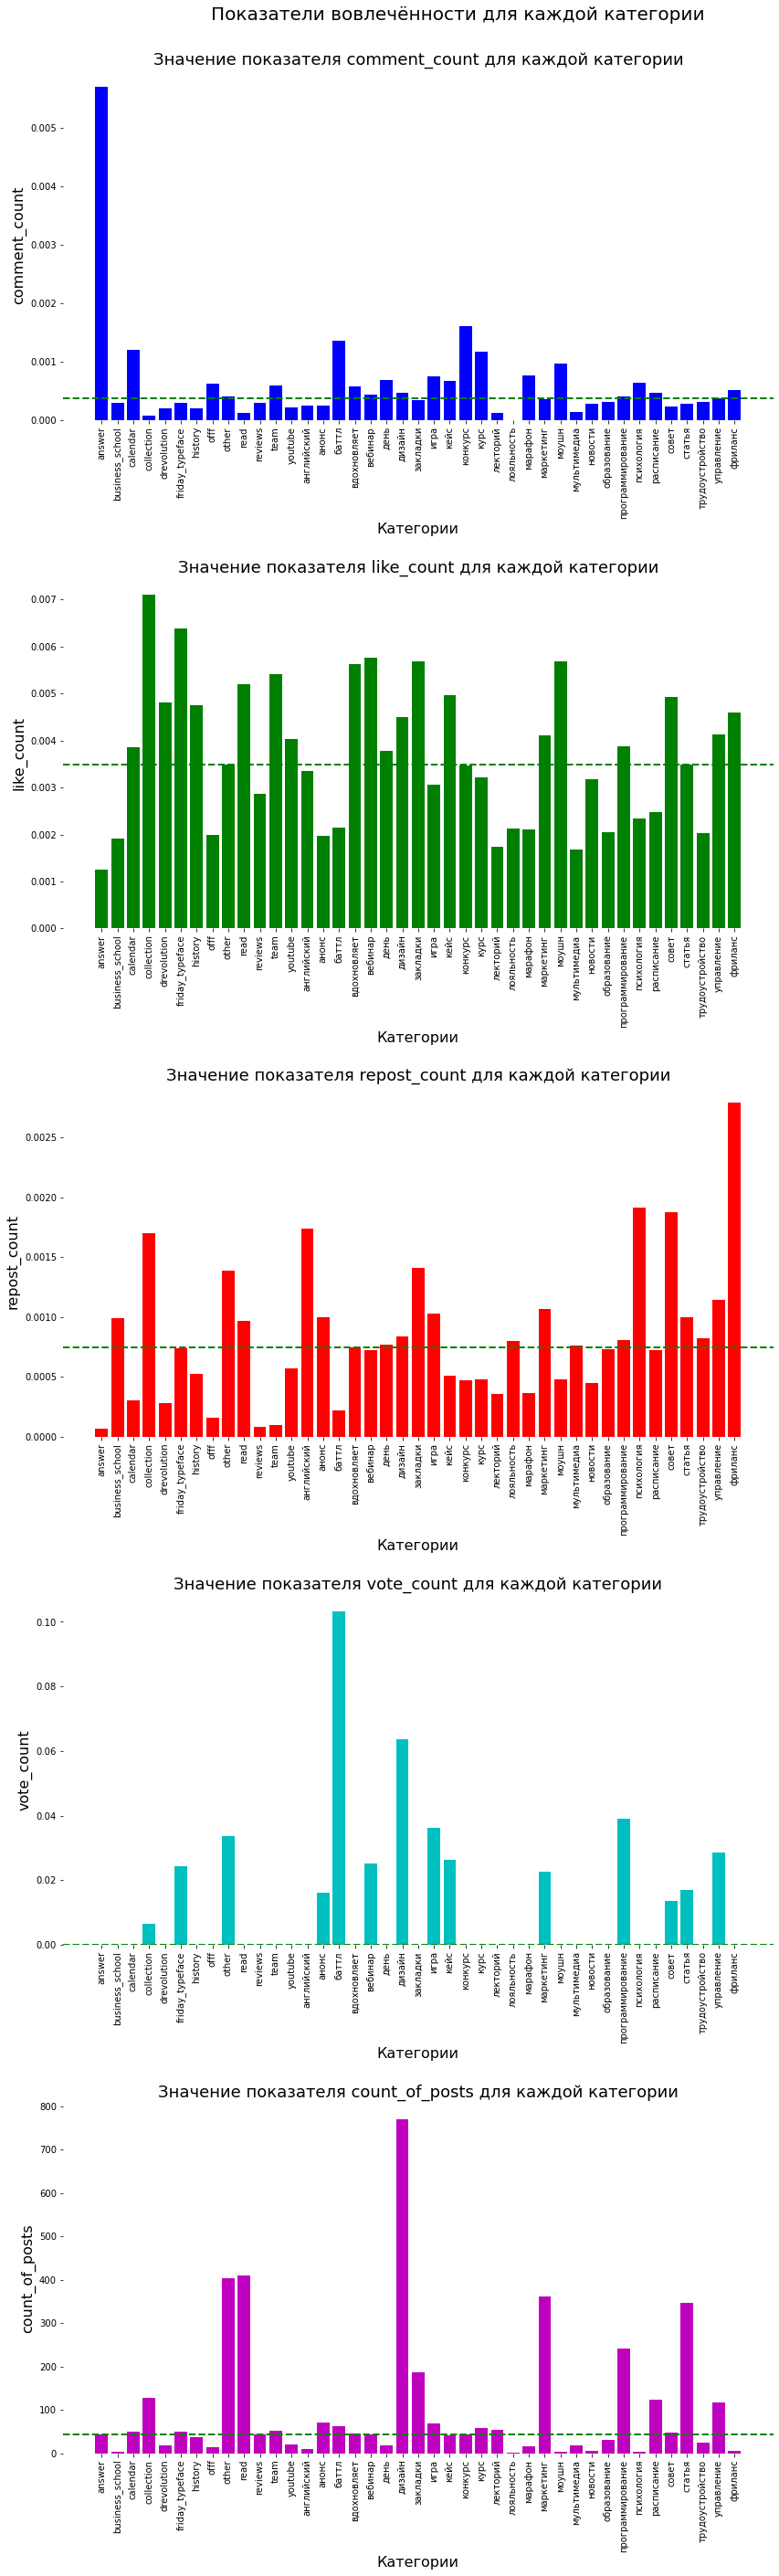

In [57]:
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

# Создадим список закодированных цветов для получения графиков разных цветов:

colors = ['b', 'g', 'r', 'c', 'm']

# Создадим список показателей:

indicator_list = ['comment_count', 'like_count', 'repost_count', 'vote_count', 'count_of_posts']

# Создадим фигуру:

fig, axs = plt.subplots(figsize=(12, 48), nrows = 5) 

# Заполним фигуры значениями из датафрейма:

for i in range(len(indicator_list)):
    
    # Создадим ссылку на элемент из списка axs:
    
    ax = axs[i]
    
    # Создадим вспомогательный датафрейм для конкретного показателя вовлечённости:
    
    if indicator_list[i] != 'count_of_posts':
    
        data = grouped_df_with_view_2_3[['category', indicator_list[i], 'view_count']] 
        
        data['indicator'] = data[indicator_list[i]]/data['view_count']
    
    else:
        
        data = grouped_df_with_view_2_3[['category', indicator_list[i]]] 
        
        data['indicator'] = data[indicator_list[i]]
    
    # Построим диаграмму, задав значения для осей x и y и указав цвет графика. Также добавим линию медианы:
    
    ax.bar(data['category'], data['indicator'], color=colors[i])
        
    ax.axhline(y=data['indicator'].median(), color='green', linewidth=2, linestyle='--')            
    
    # Установим наименование оси y:
    
    ax.set_ylabel(indicator_list[i], fontsize=16)
    
    # Установим наименование оси x:
    
    ax.set_xlabel('Категории', fontsize=16)
    
    # Установим наименование заголовка графика:

    ax.set_title('Значение показателя ' + indicator_list[i] + ' для каждой категории', fontsize=18) 
    
    # Скроем линии рамки:

    ax.spines['top'].set_visible(False)

    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_visible(False)

    ax.spines['left'].set_visible(False)
    
    # Задаим поворот значений на 90 градусов для оси x:
    
    ax.tick_params(axis='x', labelrotation=90)

# Установим наименование заголовка фигуры:
    
fig.suptitle("Показатели вовлечённости для каждой категории", y=0.90, fontsize=20) 

# Зададим отступы между графиками:

plt.subplots_adjust(wspace = 0, hspace = 0.45, left = 0)

# Покажем диаграмму:

plt.show()

## Определим категории, в которых наиболее эффективно размещать посты с точки зрения всех показателей вовлечённости:

In [146]:
grouped_df_2_4 = grouped_df_with_view_2_3.copy()

def make_relative_2(indicator):
    
    grouped_df_2_4['rilative_' + indicator] = grouped_df_2_4[indicator]/grouped_df_2_4['view_count']
    
    pass

def make_normal_2(indicator):
    
    grouped_df_2_4['normal_' + indicator] = grouped_df_2_4['rilative_'+indicator]/grouped_df_2_4['rilative_'+indicator].max()
    
    pass

# Получим новые столбцы со значениями показателей вовлечённости относительно количества просмотров.

# Приведём максимальные значения относительных показателей вовлечённости к 1:

for i in indicator_list[:-1]:
    
    make_relative_2(i)
    
    make_normal_2(i)

# Создадим новый датафрейм, в котором оставим только необходимые нам столбцы:

normal_df_2_4 = grouped_df_2_4[['category', 'normal_comment_count', 
                                'normal_like_count', 'normal_repost_count', 'normal_vote_count']]

normal_df_2_4['optimal_indicator'] = (normal_df_2_4['normal_comment_count'] + normal_df_2_4['normal_like_count'] 
                                      + normal_df_2_4['normal_repost_count'] + normal_df_2_4['normal_vote_count'])

## Рекомендуемые категории размещения (топ 15):

In [163]:
normal_df_2_4.sort_values('optimal_indicator', ascending=False).head(15)

,category,normal_comment_count,normal_like_count,normal_repost_count,normal_vote_count,optimal_indicator
40,фриланс,0.089556,0.646984,1.000000,0.000000,1.736541
3,collection,0.013749,1.000000,0.608237,0.063572,1.685557
19,дизайн,0.083116,0.632991,0.299361,0.615141,1.630609
15,баттл,0.238151,0.300978,0.077363,1.000000,1.616493
36,совет,0.040055,0.693517,0.671308,0.131414,1.536294
5,friday_typeface,0.052391,0.899405,0.265487,0.236860,1.454144
17,вебинар,0.077369,0.812007,0.259689,0.243547,1.392612
8,other,0.070491,0.489878,0.496942,0.326514,1.383825
20,закладки,0.060772,0.799575,0.505477,0.000000,1.365824
39,управление,0.066173,0.581184,0.410585,0.277133,1.335075
